# SpikeTrain Smoothing

## Goal:
- exact convolution for spike density estimation (as opposed to convolution over a discretized, binned, space)

In particular, given a `SpikeTrainArray` or a collection of events, we want to compute the exact smoothed version by convolving with a truncated Gaussian kernel. The kernel shape should be passed in as arguments (default trunc = 4 standard deviations, sigma = 100 ms), and from that, we need to determine the appropriate window specification and scale parameter for the Gaussian kernel.

Furthermore, we need to think about how we want to deal with edge conditions. We may want to do smoothing (1) within, or (2) across epochs. Furthermore, we may want to do (i) natural smoothing, cutting off any mass outside of the support, or we may choose to (ii) clump at the edge, or (iii) reflect at the edges, or (iv) re-adjust after-the-fact, etc.

I personally think natural smoothing with support for either within or across epoch smoothing would be perfect.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import nelpy as nel

%matplotlib inline

/home/etienne/anaconda3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## Exact convolution for spike density estimation

Usually we have to do something like this to get better decoding performance:

```python
ds_run = 0.125
ds_50ms = 0.05
st_run = st[run_epochs]

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

sigma = 3.1; # smoothing std dev in cm
tc = nel.TuningCurve1D(bst=bst_run, extern=pos1d, n_extern=100, extmin=0, extmax=180, sigma=sigma, min_duration=0)
```

But we can do better than binning-then-smoothing! We can concolve directly (and exactly), which better preserves the fine temporal dynamics in the spikes.

* create bins within which to aggregate
* compute bin centers
* compute offsets and bin_idx for each spike
* compute weight vector for each spike
* aggregate spike weights into the appropriate bins, by using bin_idx from above
* how about edge conditions? how about different epochs? how about which bins to keep, finally?

## example convolution

```python
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
spikes = [0.1, 0.3, 0.55, 0.56, 0.57, 0.58, 0.59, 0.62, 0.9]
```

In the above example, if we binned first, we would obtain
```python
binned = [1, 1, 5, 1, 1]
```
so that the 5 spikes in the 3rd bin would be symmetrically smoothed to both the 2nd and 4th bins (and, depending on the size of the smoothing kernel, also to the 1st and 5th bins).

However, closer inspection of the spike times reveals that they are heavily concentrated close to the right edge of the 2nd bin. In addition, the single spike in the 4th bin is close to the left edge of bin 4, so that the TRUE spike density should not have the same value at both the 2nd and 4th bins.

In [2]:
bins = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
spikes = np.array([0.1, 0.3, 0.55, 0.56, 0.57, 0.58, 0.59, 0.62, 0.9])

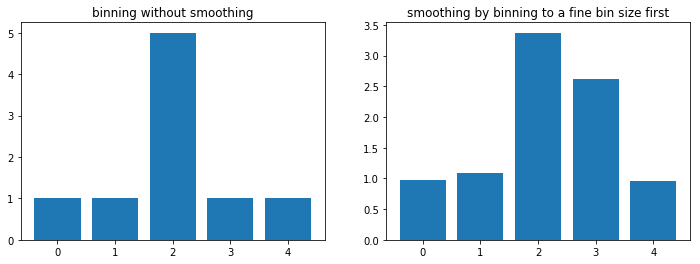

In [3]:
st = nel.SpikeTrainArray(spikes)
st.support = [0,1]

ds = 0.2

fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

# bin without smoothing
bst = st.bin(ds=ds)
n_bins = bst.n_bins

plt.bar(range(n_bins), bst.data.squeeze())
plt.title('binning without smoothing')

plt.subplot(1, 2, 2)
# smooth and re-bin:
dss = 0.01
sigma = 0.1 # 100 ms spike smoothing
bst = st.bin(ds=dss).smooth(sigma=sigma, inplace=True).rebin(w=ds/dss)

plt.bar(range(n_bins), bst.data.squeeze())
plt.title('smoothing by binning to a fine bin size first')

assert bst.data.sum() == 9, "The sum must equal 9, because we had nine spikes to spread over the bins"

### Work in progress

* We need to relate sigma to the scale and bw, so that we can set the proper scale, and have the proper window
* We also need to deal elegantly with edge conditions, within or across epochs

<BarContainer object of 5 artists>

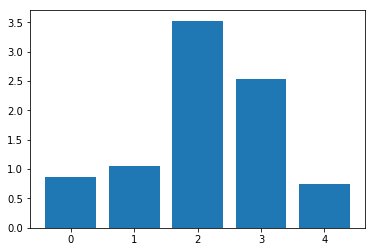

In [22]:
bin_indices = np.digitize(spikes, bins) - 1
offsets =  ds/2 - spikes + bins[bin_indices] # offset for each spike from the bin start, to the spike event

n_spikes = len(spikes)
n_bins = len(bins) - 1

bw = 1
window = np.array([[-1,0,1]])
weights = (np.repeat(np.array([[-.1,0,.1]]), n_spikes, axis=0).T + offsets/2).T
weights = scipy.stats.norm.pdf(weights, scale=0.055)

# weights = np.hstack((np.fliplr(weights[:,1:]), weights))
weights = (weights.T/weights.sum(axis=1)).T

data = np.zeros(n_bins)
for weight_vector, bin_idx in zip(weights, bin_indices):
    # decide how to deal with edge effects: across epochs? within epochs? reflect? natural?
    # for now, we ignore any mass outside of the epoch
    bin_range = (window + bin_idx).squeeze()
    weight_vector = weight_vector[(bin_range>-1) & (bin_range<n_bins)]
    bin_range = bin_range[(bin_range>-1) & (bin_range <n_bins)]
#     print('bin_range', bin_range)
    try:
        data[bin_range] += weight_vector
    except:
        pass
    
plt.bar(range(n_bins),data)

## Discussion

This notebook is not meant to be an efficient, nor a guaranteed-to-be-correct implementation, but rather a proof-of-concept starting point for thinking about the smoothing-before-binning approach. Savva has made some good progress in making this more useful and efficient, so this is only for quick reference.